In [1]:
import numpy as np
import torch

import os
from methods.io_things import download

from pde import MemoryStorage
from methods.pore_press_calc_functions import Diffusion_with_Source_and_Gravity, test_wells, get_P0_at_locs, get_perms_at_locs

from methods.base import BaseConfig

from methods.plotting import plot_perm, plot_press_plan, plot_event_list, plot_ev_dens_slice

from methods.seism_calc_functions import Micro_Seismic_Seeds, get_litostat_pressure, get_stress, \
    get_norm_and_shear_stress_on_seeds, check_colomb_criteria, get_raw_events, resample_raw_events, get_events, get_events_list, pad_events

from methods.deep_learning import EventsToPerm, TrainConfig

### Run the following cell to download model state and sample data 

In [2]:
# model weigths
if not os.path.exists('./model_states/'):
    os.makedirs('model_states')
    
download("https://huggingface.co/datasets/mexalon/microseicmic_events_to_permeability_map/resolve/main/permnet_wights.pt", './model_states/permnet_wights.pt')

./model_states/permnet_wights.pt:   0%|          | 0.00/31.3M [00:00<?, ?iB/s]

### Initial setup

In [ ]:
# one config for all. You can manually set some specific values or use params.yaml file
params = BaseConfig()
params.load('params.yaml')

### Some permeability model creation

Permeability map


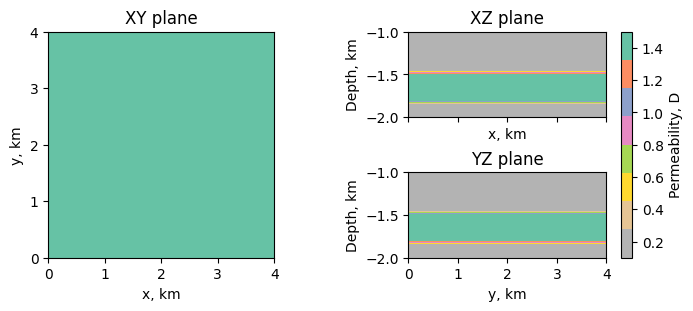

In [67]:
k0 = 100 # permeability, mD
k1 = 1500 # mD
ro0 = 2.800 # density, g/cm3
ro1 = 2.700 # g/cm3

k = k0 * np.ones(params.shape)
k[:, :, 10:17] = k1

ro = ro0 * np.ones(params.shape)
ro[:, :, 10:17] = ro1

print('Permeability map')
plot_perm(k, loc=(10, 10, 10), params=params)

### Fluid dynamics modeling

  0%|          | 0/120.0 [00:00<?, ?it/s]

  0%|          | 0/120.0 [00:00<?, ?it/s]

Pore pressure at the fimal step


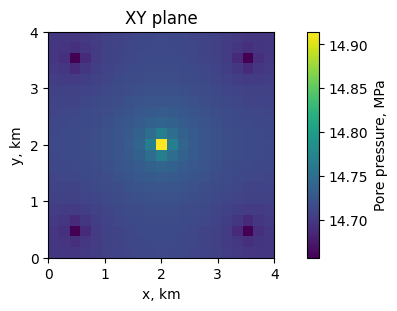

In [68]:
# Diffusion equation initial setup
eq = Diffusion_with_Source_and_Gravity(perm=k, params=params)
storage = MemoryStorage(write_mode='truncate')

p0 = eq.pore_ini_field # initial pore pressure field
p1 = eq.solve(p0, t_range=params.t_range, adaptive=True) # calculating pore pressure field at final step

p0_at_loc = [p0.interpolate(s['loc']) for s in params.sources] # initial pore pressure at source locations
p1_al_loc = [p1.interpolate(s['loc']) for s in params.sources] # final pore pressure at source locations

# calculating mutiblivators for rates baset on well injectivity
q_factors = np.ones(len(params.sources))  
for ii, s in enumerate(params.sources):
    q_factors[ii] = s['P']/(p1_al_loc[ii] - p0_at_loc[ii]) 

# updating source fields q_new = q * factor to meet the requirement for target pressure values ​​at wells
eq.source_field = eq.update_source_field(0, q_factors) 

# solving diffusion equation with proper rates
eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=['progress', storage.tracker(1)])
pore_press = np.stack(storage.data, axis=0) # Pore pressure dynamics, 4d np array

print('Pore pressure at the fimal step')
plot_press_plan(pore_press[-1], loc=(10, 10, 10), params=params)


### Seismic modeling

Events


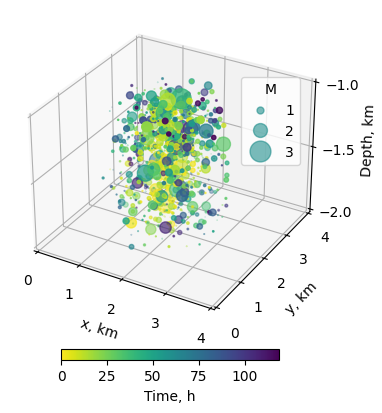

In [69]:
seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

lithostat_pressure = get_litostat_pressure(params, ro)

stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

colomb_pass = check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

raw_events = get_raw_events(params, colomb_pass) # num of seeds passed in every cell
event_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
events = get_events(params, event_dens) # events

event_list = get_events_list(events) # list of events (time, x, y, d, Mag)

events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
tot_events = np.sum(events) # total number of events

print('Events')
plot_event_list(event_list, params=params)

### Permeability reconstruction

c:\!Work\Projects\permeability_reconstruction_network\.venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Reconstructed permeability map


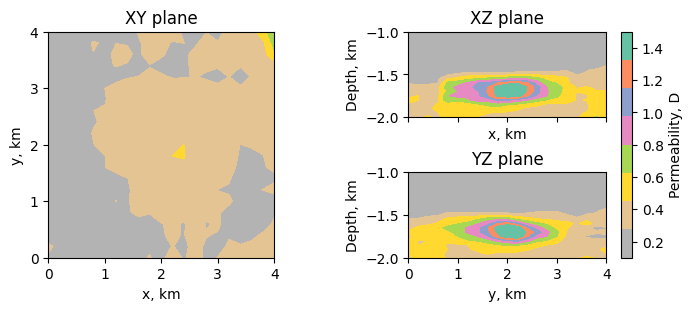

In [70]:
# model setup
pt_path = './model_states/permnet_wights.pt' # path to pt file with weights
config = TrainConfig() # model config object
model = EventsToPerm(config) # model itself 
model.load_state_dict(torch.load(pt_path)) # loading state
model.eval() # switching model to evaluation mode

# We must pad the event list with some additional -1 values ​​to ensure data consistency and convert data to torch tensor
ev_len_with_pad = params.target_events_num + params.events_list_pad # 10% padding for data shape consistency
padded_events = pad_events(event_list, ev_len_with_pad) # fills extra lines with -1 
x = torch.Tensor(padded_events).unsqueeze(0) # our x vector

# model prediction
y_hat = model(x).squeeze(0).detach().numpy()
k_hat = 10**y_hat

print('Reconstructed permeability map')
vmin_vmax = (np.min(k), np.max(k)) # for same norms
plot_perm(k_hat, loc=(10, 10, 10), params=params, vmin_vmax=vmin_vmax)